# Fine-tune the Vision Transformer on CIFAR-10

In [1]:
!pip install -q transformers datasets

# Loading the data


In [1]:
from datasets import load_dataset

# Load full CIFAR-10 dataset
train_ds, test_ds = load_dataset('cifar10', split=['train', 'test'])

# Split training into training + validation
splits = train_ds.train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']


/home/BTECH_7TH_SEM/Desktop/MML/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|███| 10000/10000 [00:00<00:00, 451432.45 examples/s]


In [2]:
train_ds

Dataset({
    features: ['img', 'label'],
    num_rows: 45000
})

In [3]:
train_ds.features

{'img': Image(mode=None, decode=True),
 'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'])}

In [4]:
train_ds[0]['label']

7

In [5]:
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}
id2label

{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [6]:
id2label[train_ds[0]['label']]

'horse'

# Preprocessing the data

# We will now preprocess the data. The model requires 2 things: pixel_values and labels.

# We will perform data augmentaton on-the-fly using HuggingFace Datasets' set_transform method (docs can be found here). This method is kind of a lazy map: the transform is only applied when examples are accessed. This is convenient for tokenizing or padding text, or augmenting images at training time for example, as we will do here. 

In [7]:
from transformers import ViTImageProcessor

processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

2025-09-30 16:28:23.127618: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-30 16:28:25.640996: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/BTECH_7TH_SEM/Desktop/MML/env/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/BTECH_7TH_

# For data augmentation, one can use any available library. Here we'll use torchvision's [transforms module](https://pytorch.org/vision/stable/transforms.html).

In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomResizedCrop(size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(size),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

In [9]:
# Set the transforms
train_ds.set_transform(train_transforms)
val_ds.set_transform(val_transforms)
test_ds.set_transform(val_transforms)

In [10]:
train_ds[:2]

{'img': [<PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
  <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>],
 'label': [7, 5],
 'pixel_values': [tensor([[[ 0.0745,  0.0745,  0.0745,  ...,  0.2549,  0.2549,  0.2549],
           [ 0.0745,  0.0745,  0.0745,  ...,  0.2549,  0.2549,  0.2549],
           [ 0.0745,  0.0745,  0.0745,  ...,  0.2549,  0.2549,  0.2549],
           ...,
           [ 0.0902,  0.0902,  0.0902,  ..., -0.0039, -0.0039, -0.0039],
           [ 0.0902,  0.0902,  0.0902,  ..., -0.0039, -0.0039, -0.0039],
           [ 0.0902,  0.0902,  0.0902,  ..., -0.0039, -0.0039, -0.0039]],
  
          [[ 0.3961,  0.3961,  0.3961,  ...,  0.5451,  0.5451,  0.5451],
           [ 0.3961,  0.3961,  0.3961,  ...,  0.5451,  0.5451,  0.5451],
           [ 0.3961,  0.3961,  0.3961,  ...,  0.5451,  0.5451,  0.5451],
           ...,
           [-0.0588, -0.0588, -0.0588,  ..., -0.0980, -0.0980, -0.0980],
           [-0.0588, -0.0588, -0.0588,  ..., -0.0980, -0.0980, -0.

In [11]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [12]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


# Define the model

Here we define the model. We define a ViTForImageClassification, which places a linear layer (nn.Linear) on top of a pre-trained ViTModel. The linear layer is placed on top of the last hidden state of the [CLS] token, which serves as a good representation of an entire image.

The model itself is pre-trained on ImageNet-21k, a dataset of 14 million labeled images. You can find all info of the model we are going to use here.

We also specify the number of output neurons by setting the id2label and label2id mapping, which we be added as attributes to the configuration of the model (which can be accessed as model.config).

In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k',
                                                  id2label=id2label,
                                                  label2id=label2id)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




# To instantiate a Trainer, we will need to define three more things. The most important is the TrainingArguments, which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional.

We also set the argument "remove_unused_columns" to False, because otherwise the "img" column would be removed, which is required for the data transformations.


In [17]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-10",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=10,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

# Accuracy score

In [18]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [19]:
import torch

trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

/tmp/ipykernel_22724/153383111.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [20]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.321800,0.078190,0.982800
2,0.251100,0.052734,0.986200
3,0.192200,0.045757,0.989800


TrainOutput(global_step=13500, training_loss=0.3349088038691768, metrics={'train_runtime': 1048.8527, 'train_samples_per_second': 128.712, 'train_steps_per_second': 12.871, 'total_flos': 1.046216869705728e+19, 'train_loss': 0.3349088038691768, 'epoch': 3.0})

In [21]:
outputs = trainer.predict(test_ds)

In [22]:
print(outputs.metrics)

{'test_loss': 0.054492656141519547, 'test_accuracy': 0.9861, 'test_runtime': 24.8631, 'test_samples_per_second': 402.203, 'test_steps_per_second': 100.551}


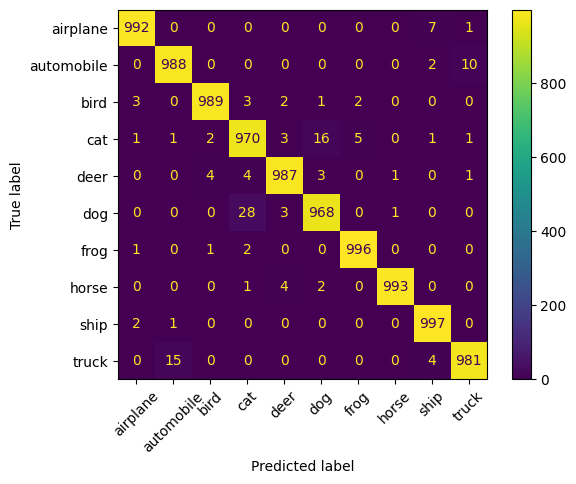

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)